In [5]:
%matplotlib widget
import open3d as o3d
import numpy as np

print("Testing IO for point cloud ...")
pcd = o3d.io.read_point_cloud("./point_cloud.pcd")

print(pcd)
print(np.asarray(pcd.points))

Testing IO for point cloud ...
PointCloud with 1003030 points.
[[-5.01554108e+00  8.34283829e+00 -1.10840452e+00]
 [ 1.42228842e-01  4.88886207e-01 -5.08561313e-01]
 [-1.66297853e-02  2.33834624e-01 -5.19577146e-01]
 ...
 [-4.26200032e-02  1.04937553e-02 -3.33869517e-01]
 [-2.86865443e-01  2.86455154e-02 -4.93457496e-01]
 [-4.62472677e-01  5.02783060e-03 -5.22608995e-01]]


In [6]:
pts = np.asarray(pcd.points)
pts_max = np.max(pts, axis=0)
pts_min = np.min(pts, axis=0)
pts_range = pts_max - pts_min

print(pts_max, pts_min, pts_range)

[143.65977478  74.63457489  18.72026062] [-61.98277664 -39.56433868 -28.18582535] [205.64255142 114.19891357  46.90608597]


In [7]:
centre = (pts_max + pts_min) / 2
centre[0] = 0
centre[1] = 0
centre[2] = 0
print(centre)
sides = 4
half_sides = sides / 2
polygon = [
        list(centre + [half_sides, half_sides, 0]),
        list(centre + [-half_sides, half_sides, 0]),
        list(centre + [-half_sides, -half_sides, 0]),
        list(centre + [half_sides, -half_sides, 0]),
    ]
cropped = {
    "axis_max": 10,
    "axis_min": -10,
    "class_name": "SelectionPolygonVolume",
    "orthogonal_axis": "Z",
    "bounding_polygon": polygon,
    "version_major": 1,
    "version_minor": 0,
}

import json

with open("cropped_rect.json", "w") as f:
    f.write(json.dumps(cropped))

print(
    centre,
    list(centre + [half_sides, half_sides, 0]),
    list(centre + [-half_sides, half_sides, 0]),
)

[0. 0. 0.]
[0. 0. 0.] [2.0, 2.0, 0.0] [-2.0, 2.0, 0.0]


In [8]:
vol = o3d.visualization.read_selection_polygon_volume("cropped_rect.json")
cropped_pcd = vol.crop_point_cloud(pcd)

pts = np.asarray(cropped_pcd.points)
print(pts)
pts_max = np.max(pts, axis=0)
pts_min = np.min(pts, axis=0)
pts_range = pts_max - pts_min

print(pts_max, pts_min, pts_range)

[[ 0.14222884  0.48888621 -0.50856131]
 [-0.01662979  0.23383462 -0.51957715]
 [-0.45896342 -0.69580227 -0.49206024]
 ...
 [-0.04262     0.01049376 -0.33386952]
 [-0.28686544  0.02864552 -0.4934575 ]
 [-0.46247268  0.00502783 -0.522609  ]]
[ 1.99992204  1.99998069 -0.1618062 ] [-1.99985969 -1.99995244 -1.9966526 ] [3.99978173 3.99993312 1.83484641]


In [9]:
print(len(pts))

pts_downsampled_idx = np.random.choice(np.arange(pts.shape[0]), 10000, replace=False)
pts_downsampled = pts[pts_downsampled_idx]

627767


[0.00148386 0.06173333 0.99809158]


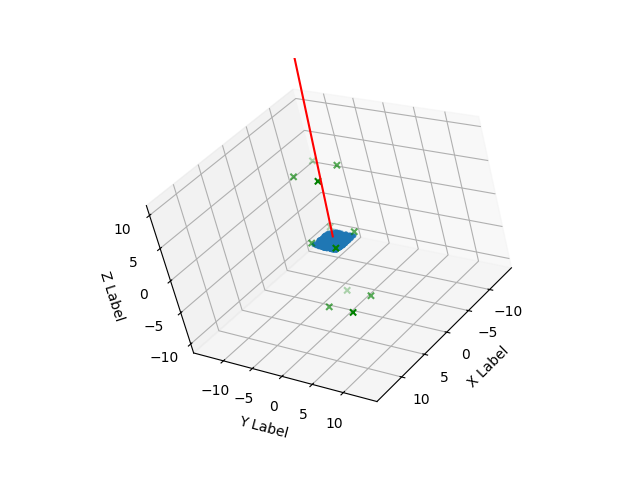

In [10]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pts_downsampled[:,0], pts_downsampled[:,1], pts_downsampled[:,2], marker=".")
ax.scatter(centre[0], centre[1], centre[2], marker="x", color="red")
polygon = np.array(polygon)
ax.scatter(polygon[:,0], polygon[:,1], polygon[:,2], marker="x", color="green")
polygon[:,2] = 10
ax.scatter(polygon[:,0], polygon[:,1], polygon[:,2], marker="x", color="green")
polygon[:,2] = -10
ax.scatter(polygon[:,0], polygon[:,1], polygon[:,2], marker="x", color="green")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')

m, c = pcd.compute_mean_and_covariance()

eigen_vectors = np.linalg.eig(c)[1]  
k = eigen_vectors.T[2]

# normalise vector k
k = k / np.linalg.norm(k)

print(k)
k = k * 50
plt.quiver(0,0,0, k[0],k[1],k[2], color="red")

# turn camera view point in the 3d plot
ax.view_init(elev=30, azim=45, roll=15)




In [11]:
o3d.io.write_point_cloud("cropped_point_cloud.pcd", cropped_pcd)


True

In [12]:

import plotly.graph_objects as go
import chart_studio.plotly as py

marker_data = go.Scatter3d(
    x=pts[:,0], 
    y=pts[:,1], 
    z=pts[:,2], 
    marker=go.scatter3d.Marker(size=3), 
    opacity=0.8, 
    mode='markers'
)
fig=go.Figure(data=marker_data)

py.iplot(fig)


/Users/liyouzhou/.pyenv/versions/3.10.13/lib/python3.10/site-packages/chart_studio/plotly/plotly.py:222: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



PlotlyRequestError: Authentication credentials were not provided.

In [ ]:
print("octree division")
octree = o3d.geometry.Octree(max_depth=9)
octree.convert_from_point_cloud(cropped_pcd, size_expand=0.01)
o3d.io.write_octree("octree.json", octree)

octree division


True

In [ ]:

import fcl

with open("cropped_point_cloud.bt", "rb") as f:
    s = f.read()

print(s)
l = []
for b in s:
    l.append(int(b))

print(l)
print(type(s))
octree_node = fcl.OcTree(0.2, s)

b'# Octomap OcTree binary file\n# (feel free to add / change comments, but leave the first line as it is!)\n#\nid OcTree\nsize 13973\nres 0.05\ndata\n\xff\x00\x00\xc0\x00\xc0\x00\xc0\x00\xc0\x00\xc0\x00\xc0\x00\xc0\x00\xc0\x00\xc0\x00\xff\x00\xc0\xc0\xc0\x00\xff\x00\xff\x08\x02\x00*\x08\xa0\x00*\x0c\xff\x00\x08\xaa\x02\xa0\x08 (\n\x00\xc0\xcc\x00\x02\x08\x00\x08\x08\x03?\x00\x80\x02\x02\xa2\xaa\x02\x00\x03\x00\x03\x00\xa0\x00\x00\xf0\xf0\xf0\x00\xff\x00\xff\xa8\x00(\xaa\xa2\x02\x00\x88\x00\xff\xa0\xaa \xaa\x08\xaa\x80\xaa\x00\xff\n\xa2\x08*\x00"\x00\xa8\x03\xff\x00\x02\xa0\xaa \xaa\x88\x8a\x00\xaa\x00\xff\x00\xff\x02\xaa\x00\xa8\x00\xaa\x00\xaa\x00\xff\x00\xa8\x88\xaa\x80\xaa\x02\xaa\x00\xff\x02\xaa\x82\xaa\x00\xaa"\xaa\x00\xff\x80\xaa"\xaa\x00\xaa\x80\xaa\xcf\x00\x0c\x00\x80\x003\x00\x80\x00\x08\x00\x0c\x00\x80\x00\xff\x00\xff\x00\n\x00\xaa\x00\x08\x00\x8a\x00\xff\x00\x08\x00\xaa\x00\xaa\x00\xaa\x00\x03\x00 \x00\xcf\x00\x08\x00\xaa\x00\xa8\x00\xf0\xf0\x00\xff\x00\xff\x00\xaa\x88\xa8\x

OverflowError: value too large to convert to char

In [ ]:


b_sides = [1,1,1]
b = fcl.Box(*b_sides)    
tf = fcl.Transform()

obj = fcl.CollisionObject(b, tf)

request = fcl.CollisionRequest()
result = fcl.CollisionResult()

# ret = fcl.collide(o1, o2, request, result)

In [ ]:
with open("cropped_point_cloud.bt", "br") as f:
    for i in range(3):
        header = f.readline()
        print(header)
    id = f.readline().split()[-1]
    size = int(f.readline().split()[-1])
    res = float(f.readline().split()[-1])
    print(f"id {id}, size {size}, res {res}")
    data_header = f.readline()
    data = f.read()

for line in data:
    print(line)

b'# Octomap OcTree binary file\n'
b'# (feel free to add / change comments, but leave the first line as it is!)\n'
b'#\n'
id b'OcTree', size 13973, res 0.05
255
0
0
192
0
192
0
192
0
192
0
192
0
192
0
192
0
192
0
192
0
255
0
192
192
192
0
255
0
255
8
2
0
42
8
160
0
42
12
255
0
8
170
2
160
8
32
40
10
0
192
204
0
2
8
0
8
8
3
63
0
128
2
2
162
170
2
0
3
0
3
0
160
0
0
240
240
240
0
255
0
255
168
0
40
170
162
2
0
136
0
255
160
170
32
170
8
170
128
170
0
255
10
162
8
42
0
34
0
168
3
255
0
2
160
170
32
170
136
138
0
170
0
255
0
255
2
170
0
168
0
170
0
170
0
255
0
168
136
170
128
170
2
170
0
255
2
170
130
170
0
170
34
170
0
255
128
170
34
170
0
170
128
170
207
0
12
0
128
0
51
0
128
0
8
0
12
0
128
0
255
0
255
0
10
0
170
0
8
0
138
0
255
0
8
0
170
0
170
0
170
0
3
0
32
0
207
0
8
0
170
0
168
0
240
240
0
255
0
255
0
170
136
168
0
160
0
170
0
255
0
162
34
160
0
170
2
170
0
255
8
170
32
170
136
170
168
170
48
255
0
128
0
170
162
170
0
170
168
170
0
255
0
255
0
40
0
136
0
162
0
128
0
252
0
32
0
170
0
160

In [35]:
def bits(f):
    bytes = f.read()
    for b in bytes:
        for i in range(8):
            yield (b >> i) & 1


class Node:
    FREE = 0
    OCCUPIED = 1
    CHILDREN = 2
    UNDEFINED = 3

    def __init__(self, status):
        if status[0] == 1 and status[1] == 0:
            # child is a free leaf
            self.status = Node.FREE
        elif status[0] == 0 and status[1] == 1:
            # child is a occupied leaf
            self.status = Node.OCCUPIED
        elif status[0] == 1 and status[1] == 1:
            # child has children
            self.status = Node.CHILDREN
        else:
            self.status = Node.UNDEFINED

        self.children = []

    def has_children(self):
        return self.status == Node.CHILDREN

    def add_child(self, node):
        self.children.append(node)


def add_children(node, nodes, idx):
    for i in range(8):
        child = Node(nodes[idx + i])
        node.add_child(child)

    idx += 8

    children = node.children
    for i, child in enumerate(children):
        if child.has_children():
            child, idx = add_children(child, nodes, idx)
            node.children[i] = child

    return node, idx


class BinaryOctree:
    def __init__(self, fn="cropped_point_cloud.bt"):
        self.nodes = []

        with open(fn, "br") as f:
            for i in range(3):
                header = f.readline()
                print(header)
            id = f.readline().split()[-1]
            size = int(f.readline().split()[-1])
            res = float(f.readline().split()[-1])
            print(f"id {id}, size {size}, res {res}")
            data_header = f.readline()

            self.data = bits(f)

            node = []
            for idx, bit in enumerate(self.data):
                if idx % 2 == 0:
                    node = [bit]
                else:
                    node.append(bit)
                    self.nodes.append(node)

        root = Node([1, 1])
        idx = 0
        root, idx = add_children(root, self.nodes, idx)

        def print_tree(parent):
            print(parent)
            for child in parent.children:
                print_tree(child)

        print_tree(root)

        self.root = root

    def serialize(self, fn):
        def serialize_node(node):
            s = {}
            if node.has_children():
                s["class_name"] = "OctreeInternalPointNode"
                s["children"] = []
                for child in node.children:
                    s["children"].append(serialize_node(child))
            else:
                s["class_name"] = "OctreeColorLeafNode"
                s["color"] = [255, 255, 0]
            return s

        s = serialize_node(self.root)

        ss = {
            "class_name": "Octree",
            "max_depth": self.max_depth(),
            "origin": [-1.9999353885650635, -1.9999524354934692, -3.079195961356163],
            "size": 4.0399324548244477,
            "tree": s,
        }

        with open(fn, "w") as f:
            json.dump(ss, f, indent=4)
        # for node in self.nodes:
        #     print(node, len(self.nodes))

    def max_depth(self):
        def max_depth(parent):
            if not parent.has_children():
                return 0
            return 1+ max([max_depth(child) for child in parent.children])
        
        return max_depth(self.root)


bo = BinaryOctree()
bo.serialize("octree_dumped.json")

# load octree from json
octree = o3d.geometry.Octree(max_depth=bo.max_depth())
octree = o3d.io.read_octree("octree_dumped.json")

b'# Octomap OcTree binary file\n'
b'# (feel free to add / change comments, but leave the first line as it is!)\n'
b'#\n'
id b'OcTree', size 104012, res 0.005


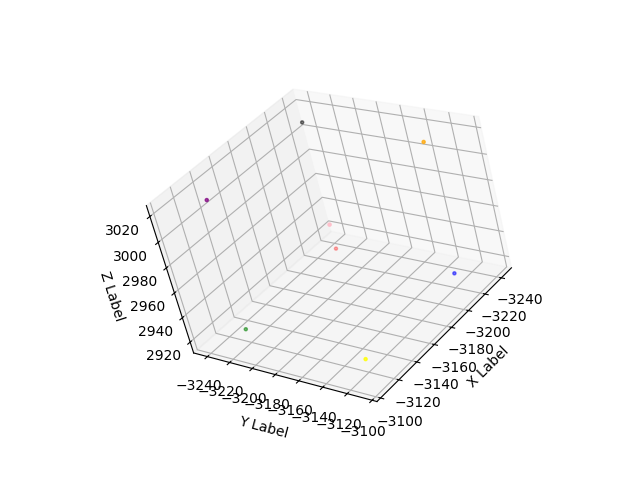

In [14]:
s = """Node center: (-3225.55 -3225.55 2918.45) 0.1
Node center: (-3123.15 -3225.55 2918.45) 0.1
Node center: (-3225.55 -3123.15 2918.45) 0.1
Node center: (-3123.15 -3123.15 2918.45) 0.1
Node center: (-3225.55 -3225.55 3020.85) 0.1
Node center: (-3123.15 -3225.55 3020.85) 0.1
Node center: (-3225.55 -3123.15 3020.85) 0.1
Node center: (-3123.15 -3123.15 3020.85) 0.1
"""

pts = []
for line in s.split("\n"):
    if len(line) > 0:
        x = float(line.split()[2].strip("("))
        y = float(line.split()[3])
        z = float(line.split()[4].strip(")"))
        pts.append([x,y,z])

pts = np.array(pts)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], marker=".", color=["red", "green", "blue", "yellow", "black", "purple", "orange", "pink"])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')

# turn camera view point in the 3d plot
ax.view_init(elev=30, azim=45, roll=15)


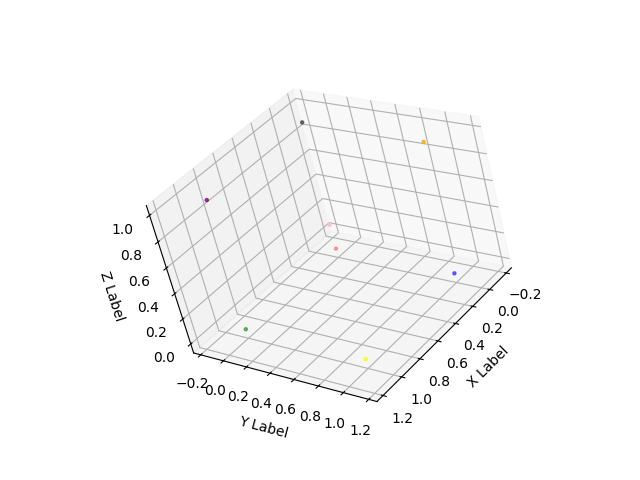

In [15]:
pts = []
for i in range(8):
    x = i % 2
    y = (i // 2) % 2
    z = i // 4 % 2
    pts.append([x,y,z])
    
pts = np.array(pts)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], marker=".", color=["red", "green", "blue", "yellow", "black", "purple", "orange", "pink"])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')

# turn camera view point in the 3d plot
ax.view_init(elev=30, azim=45, roll=15)

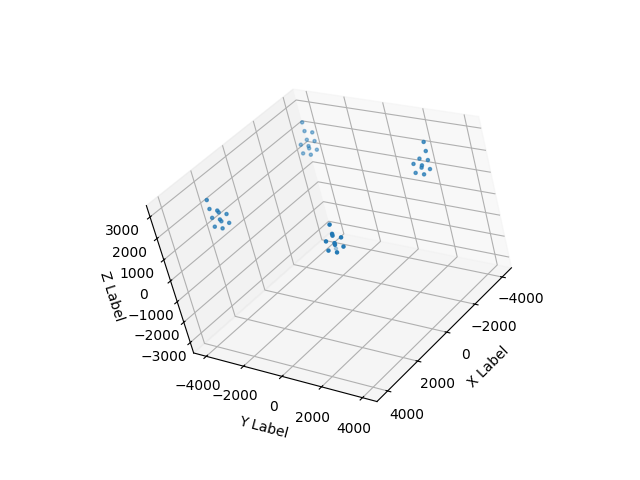

In [17]:
s = """Node center: (0 0 0) 1.6
32768 32768 32768 
Node center: (-1638 -1638 -1638) 0.8
16384 16384 16384 
Node center: (-2457.4 -2457.4 -2457.4) 0.4
8192 8192 8192 
Node center: (-2867.1 -2867.1 -2867.1) 0.2
4096 4096 4096 
Node center: (-3071.95 -3071.95 -3071.95) 0.1
2048 2048 2048 
Node center: (-1638 -1638 1638.8) 0.8
16384 16384 49152 
Node center: (-2457.4 -2457.4 819.4) 0.4
8192 8192 40960 
Node center: (-2867.1 -2867.1 1228.9) 0.2
4096 4096 45056 
Node center: (-2457.4 -2457.4 2457.8) 0.4
8192 8192 57344 
Node center: (-2867.1 -2867.1 2048.1) 0.2
4096 4096 53248 
Node center: (-3071.95 -3071.95 1843.25) 0.1
2048 2048 51200 
Node center: (-2662.35 -3071.95 1843.25) 0.1
6144 2048 51200 
Node center: (-3071.95 -2662.35 1843.25) 0.1
2048 6144 51200 
Node center: (-2662.35 -2662.35 1843.25) 0.1
6144 6144 51200 
Node center: (-3071.95 -3071.95 2252.85) 0.1
2048 2048 55296 
Node center: (-2662.35 -3071.95 2252.85) 0.1
6144 2048 55296 
Node center: (-3071.95 -2662.35 2252.85) 0.1
2048 6144 55296 
Node center: (-2662.35 -2662.35 2252.85) 0.1
6144 6144 55296 
Node center: (-2867.1 -2867.1 2867.3) 0.2
4096 4096 61440 
Node center: (-3071.95 -3071.95 2662.45) 0.1
2048 2048 59392 
Node center: (-3071.95 -2662.35 2662.45) 0.1
2048 6144 59392 
Node center: (-3071.95 -3071.95 3072.05) 0.1
2048 2048 63488 
Node center: (1638.8 -1638 1638.8) 0.8
49152 16384 49152 
Node center: (2457.8 -2457.4 819.4) 0.4
57344 8192 40960 
Node center: (2867.3 -2867.1 1228.9) 0.2
61440 4096 45056 
Node center: (2457.8 -2457.4 2457.8) 0.4
57344 8192 57344 
Node center: (2867.3 -2867.1 2048.1) 0.2
61440 4096 53248 
Node center: (2662.45 -3071.95 1843.25) 0.1
59392 2048 51200 
Node center: (3072.05 -3071.95 1843.25) 0.1
63488 2048 51200 
Node center: (2662.45 -2662.35 1843.25) 0.1
59392 6144 51200 
Node center: (3072.05 -2662.35 1843.25) 0.1
63488 6144 51200 
Node center: (2662.45 -3071.95 2252.85) 0.1
59392 2048 55296 
Node center: (3072.05 -3071.95 2252.85) 0.1
63488 2048 55296 
Node center: (2662.45 -2662.35 2252.85) 0.1
59392 6144 55296 
Node center: (3072.05 -2662.35 2252.85) 0.1
63488 6144 55296 
Node center: (2867.3 -2867.1 2867.3) 0.2
61440 4096 61440 
Node center: (3072.05 -3071.95 2662.45) 0.1
63488 2048 59392 
Node center: (3072.05 -2662.35 2662.45) 0.1
63488 6144 59392 
Node center: (3072.05 -3071.95 3072.05) 0.1
63488 2048 63488 
Node center: (-1638 1638.8 1638.8) 0.8
16384 49152 49152 
Node center: (-2457.4 2457.8 819.4) 0.4
8192 57344 40960 
Node center: (-2867.1 2867.3 1228.9) 0.2
4096 61440 45056 
Node center: (-2457.4 2457.8 2457.8) 0.4
8192 57344 57344 
Node center: (-2867.1 2867.3 2048.1) 0.2
4096 61440 53248 
Node center: (-3071.95 2662.45 1843.25) 0.1
2048 59392 51200 
Node center: (-2662.35 2662.45 1843.25) 0.1
6144 59392 51200 
Node center: (-3071.95 3072.05 1843.25) 0.1
2048 63488 51200 
Node center: (-2662.35 3072.05 1843.25) 0.1
6144 63488 51200 
Node center: (-3071.95 2662.45 2252.85) 0.1
2048 59392 55296 
Node center: (-2662.35 2662.45 2252.85) 0.1
6144 59392 55296 
Node center: (-3071.95 3072.05 2252.85) 0.1
2048 63488 55296 
Node center: (-2662.35 3072.05 2252.85) 0.1
6144 63488 55296 
Node center: (-2867.1 2867.3 2867.3) 0.2
4096 61440 61440 
Node center: (-3071.95 3072.05 2662.45) 0.1
2048 63488 59392 
Node center: (-3071.95 3072.05 3072.05) 0.1
2048 63488 63488 
Node center: (1638.8 1638.8 1638.8) 0.8
49152 49152 49152 
Node center: (2457.8 2457.8 819.4) 0.4
57344 57344 40960 
Node center: (2867.3 2867.3 1228.9) 0.2
61440 61440 45056 
Node center: (2457.8 2457.8 2457.8) 0.4
57344 57344 57344 
Node center: (2867.3 2867.3 2048.1) 0.2
61440 61440 53248 
Node center: (2662.45 2662.45 1843.25) 0.1
59392 59392 51200 
Node center: (3072.05 2662.45 1843.25) 0.1
63488 59392 51200 
Node center: (2662.45 3072.05 1843.25) 0.1
59392 63488 51200 
Node center: (3072.05 3072.05 1843.25) 0.1
63488 63488 51200 
Node center: (2662.45 2662.45 2252.85) 0.1
59392 59392 55296 
Node center: (3072.05 2662.45 2252.85) 0.1
63488 59392 55296 
Node center: (2662.45 3072.05 2252.85) 0.1
59392 63488 55296 
Node center: (3072.05 3072.05 2252.85) 0.1
63488 63488 55296 
Node center: (2867.3 2867.3 2867.3) 0.2
61440 61440 61440 
Node center: (3072.05 3072.05 2662.45) 0.1
63488 63488 59392 
Node center: (3072.05 3072.05 3072.05) 0.1
63488 63488 63488 
"""

pts = []
for line in s.split("\n"):
    if len(line) > 0 and line.endswith("0.1"):
        x = float(line.split()[2].strip("("))
        y = float(line.split()[3])
        z = float(line.split()[4].strip(")"))
        pts.append([x,y,z])

pts = np.array(pts)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], marker=".")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')

# turn camera view point in the 3d plot
ax.view_init(elev=30, azim=45, roll=15)


697607


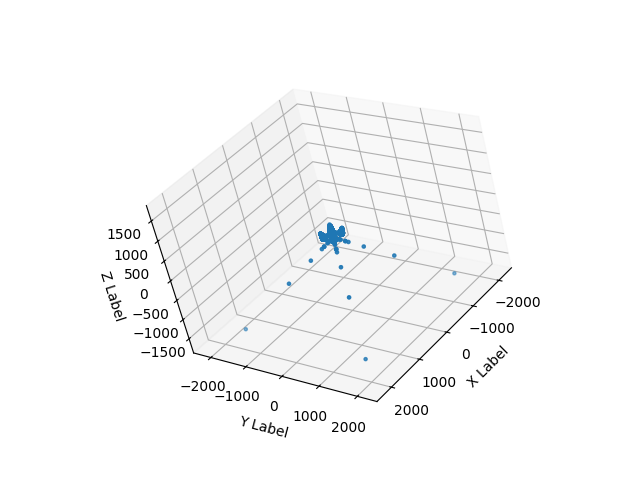

In [41]:
pts = []

with open("pcd2bt/build/debug_16_levels.txt", "r") as fd:
    for line in fd:
        if len(line) > 0 and line.strip().startswith("Node center"):
            x = float(line.split()[2].strip("("))
            y = float(line.split()[3])
            z = float(line.split()[4].strip(")"))
            val = float(line.split()[-1])

            if val > 0:
                pts.append([x,y,z])

print(len(pts))
pts = np.array(pts)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], marker=".")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')

# turn camera view point in the 3d plot
ax.view_init(elev=30, azim=45, roll=15)